# Trajectories by simple integration for advected waves and unadvected waves

In [2]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

In [3]:
#Main parameters
d2s=86400 #24h in s
h2s=3600  #1h in s
w2=2*2*np.pi/86400 #wave pulsation
km=1e3
dt=1*h2s # model step
L=100*km
k2=2*np.pi/L


## Classes

In [4]:
@xs.process
class Position:
    """Compute the evolution of positions"""

    p_vars = xs.group("p_vars")
    p = xs.variable(dims="a", intent="inout", description="positions of particules", attrs={"units": "m"})
    
    def run_step(self):
        self._delta_p = sum((x for x in self.p_vars))
        
    def finalize_step(self):
        self.p += self._delta_p #p(t+dt)


In [5]:
def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return (um + uw*np.cos(w*t-k*x))


@xs.process
class Velocity_Field:
    """Initiate the Eulerian velocity field on a grid"""
    
    #velocity parameters
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})
    advected = xs.variable(description="advected wave", attrs={"units":"1"})#booléen
    
    #grid parameters
    t_i = xs.variable(description="starting time", attrs={"units":"s"})
    t_e = xs.variable(description="ending time", attrs={"units":"s"})
    t_step = xs.variable(description="time step", attrs={"units":"s"})
    x_i = xs.variable(description="first limit of positions", attrs={"units":"m"})
    x_e = xs.variable(description="end limit of positions", attrs={"units":"m"})
    x_step = xs.variable(description="position step", attrs={"units":"m"})
    
    #analytical function
    def velocity_func(self, *args):
        if self.advected:
            return analytical_velocity_advected(*args)
        else:
            return analytical_velocity_unadvected(*args)
        
    # variables
    VF= xs.variable(dims=("t","x"), description="Eulerian velocity field",intent='out')
    x = xs.index(dims="x")
    t = xs.index(dims="t")

    
    @xs.runtime()
    def initialize(self):
        self.t=np.arange(self.t_i,self.t_e,self.t_step)
        self.x=np.arange(self.x_i,self.x_e,self.x_step)
        print(self.x[-1], self.t[-1])
        len_t=len(self.t)
        len_x=len(self.x)
        self.VF=np.zeros((len_t, len_x))
        for i in range(len_t):
            for j in range (len_x):
                self.VF[i,j]=analytical_velocity_advected(self.t[i], self.x[j], self.um, self.uw, self.w, self.k)

In [6]:
def bilinear_int(p_liste, ts, VF, x, t, t_step, x_step):
    v=[]
    it1 = np.searchsorted(t,ts, side='right')-1
    it2 = it1 + 1
    #print(it1,it2)
    if it2>=len(t):
        print('t out of velocity flield :'+str(ts))
        return np.zeros_like(p_liste)
    for p in p_liste:
        ip1 = np.searchsorted(x,p, side='right')-1
        if ip1+1>=len(x):
            print('x out of velocity flield')
            v.append(0)
        else:
            ip2 = ip1 + 1
            #print(ip1,ip2)
        
            alpha=p-x[ip1]
            beta=ts-t[it1]
        
    
            delta_vx = VF[it1,ip2]-VF[it1,ip1]
            delta_vy = VF[it2,ip1]-VF[it1,ip1]
            delta_vxy = VF[it1,ip1] + VF[it2,ip2] - VF[it1,ip2] - VF[it2,ip1]
            v.append(delta_vx*alpha/x_step + delta_vy*beta/t_step + delta_vxy*alpha*beta/x_step/t_step + VF[it1,ip1])
    return v

@xs.process
class Velocity:
    """Compute the evolution of positions"""
    
    inter_method = xs.variable(description="Interpolation_method")
    v = xs.variable(dims="a", intent="out", description="velocity of particules", attrs={"units": "m"})
    
    VF = xs.foreign(Velocity_Field, 'VF')
    t = xs.foreign(Velocity_Field, 't')
    x = xs.foreign(Velocity_Field, 'x')
    t_step = xs.foreign(Velocity_Field, 't_step')
    x_step = xs.foreign(Velocity_Field, 'x_step')
    p = xs.foreign(Position, 'p')
     
    #interpolation function
    def interpolation_func(self,p, ts):
        if self.inter_method == 'bilinear':
            return bilinear_int(p, ts, self.VF, self.x, self.t, self.t_step, self.x_step)
        
    
    #INITIALISATION OF VELOCITY
    @xs.runtime(args="sim_start") #this way t is the beginning time of the simulation
    def initialize(self,ts):
        self.v = self.interpolation_func(self.p, ts)

         
    @xs.runtime(args=["step_start"])
    def run_step(self, ts):
        self.v = self.interpolation_func(self.p, ts)# v(x(t),t)
        if len(self.v)==50:
            print(ts)
        
        
    #CALCULATION OF VELOCITY AT t time and position p
    @xs.runtime(args=["step_end"])
    def finalize_step(self, te):
        self.v = self.interpolation_func(self.p, te) # v(x(t+dt),t+dt)
        
    

In [7]:
@xs.process
class InitPRegular:
    """Initialize `positions` profile with N regular values in a giving an interval."""

    mini = xs.variable(description="minimum for initial position", static=True)
    maxi = xs.variable(description="maximum for initial position", static=True)
    N = xs.variable(description="number of particules", static=True)
    
    a = xs.index(dims="a")

    p = xs.foreign(Position, "p", intent="out")
    
    def initialize(self):
        self.a = np.linspace(self.mini, self.maxi, self.N)
        self.p = self.a.copy()


In [8]:
@xs.process
class Euler:
    """Calculate positions at t+dt using Euler method.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")
    v = xs.foreign(Velocity, "v", intent="in")


    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.p_advected = self.v*dt #self.v=v(x,t)

In [9]:
@xs.process
class Runge_Kutta2:
    """Calculate positions at t+dt using Runge-Kutta method of order 2.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")

    v = xs.foreign(Velocity, "v", intent="in")
    p = xs.foreign(Position, "p", intent="in")
    VF = xs.foreign(Velocity_Field, 'VF', intent='in')
    t_step = xs.foreign(Velocity_Field, 't_step')
    x_step = xs.foreign(Velocity_Field, 'x_step')
    t = xs.foreign(Velocity_Field, 't')
    x = xs.foreign(Velocity_Field, 'x')

    #interpolation function
    def interpolation_func(self,*args):
        if self.inter_method == 'bilinear':
            return bilinear_int(*args)
        
        
    @xs.runtime(args=["step_delta", "step_start"])
    def run_step(self, dt,ts):
        self._p1 =self.p + self.v*dt
        self.p_advected = dt/2*(self.v + self.interpolation_func(self._p1,ts))

In [10]:
@xs.process
class Runge_Kutta4:
    """Calculate positions at t+dt using Runge-Kutta method of order 4.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")

    v = xs.foreign(Velocity, "v", intent="in")
    p = xs.foreign(Position, "p", intent="in")
    VF = xs.foreign(Velocity_Field, 'VF', intent='in')
    t_step = xs.foreign(Velocity_Field, 't_step')
    x_step = xs.foreign(Velocity_Field, 'x_step')
    t = xs.foreign(Velocity_Field, 't')
    x = xs.foreign(Velocity_Field, 'x')
    

    #interpolation function
    def interpolation_func(self,*args):
        if self.inter_method == 'bilinear':
            return bilinear_int(*args)
        

    @xs.runtime(args=["step_delta", "step_start"])
    def run_step(self, dt,ts):
        
        t2=ts+dt/2

        self._p1 = self.p + dt/2 * self.v
        self._v1 = self.interpolation_func(self._p1, t2)# v(p1, t+dt/2)
        
        self._p2 = self.p + dt/2 * self._v1 
        self._v2 = self.interpolation_func(self._p2, t2)# v(p2, t+dt/2)
        
        self._p3 = self.p + dt * self._v2
        self._v3 = self.interpolation_func(self._p3, ts+dt)# v(p3, t+dt)
        
        
        self.p_advected = dt/6 *( self.v + 2*self._v2 + self._v3 + 2*self._v1)
        

In [11]:
intmethod=Runge_Kutta4
init_p=InitPRegular
time= list(np.arange(0,d2s*4, h2s/2))
otime=list(np.arange(0, d2s*4, h2s))
init_mini=0
init_maxi=2*L
init_N=100
um=0.1
uw=0.1
w=w2
k=k2
advected=1
inter_method='bilinear'
t_i, t_e, t_step = 0, 10*d2s,3600/5 
x_i, x_e, x_step =0, 5*L, 10*km

model= xs.Model({
    "v_field": Velocity_Field,
    "position": Position,
    "init": InitPRegular,
    "intmethod": Euler,
    "velocity": Velocity
    
})
in_ds=xs.create_setup(model=model,
                      clocks={'time': time,
                                    'otime': otime},
                      master_clock='time',
                      input_vars={'init': {'mini': init_mini, 'maxi':init_maxi, 'N':init_N},
                                    'v_field': {'um': um, 'uw': uw, 'w':w, 'k':k, 'advected':advected, 't_i':t_i, 't_e':t_e, 't_step':t_step, 'x_i':x_i, 'x_e':x_e, 'x_step':x_step},
                                  'velocity':{'inter_method': 'bilinear'}
                                    },
                        output_vars={'position__p' : 'otime', 'velocity__v':'otime'})

out_ds=in_ds.xsimlab.run(model=model)
out_ds

490000.0 863280.0
t out of velocity flield :nan


<xarray.Dataset>
Dimensions:                 (a: 100, otime: 96, t: 1200, time: 192, x: 50)
Coordinates:
  * a                       (a) float64 0.0 2.02e+03 4.04e+03 ... 1.98e+05 2e+05
  * otime                   (otime) int64 0 3600 7200 ... 334800 338400 342000
  * t                       (t) float64 0.0 720.0 ... 8.626e+05 8.633e+05
  * time                    (time) float64 0.0 1.8e+03 ... 3.42e+05 3.438e+05
  * x                       (x) float64 0.0 1e+04 2e+04 ... 4.8e+05 4.9e+05
Data variables: (12/17)
    init__N                 int64 100
    init__maxi              float64 2e+05
    init__mini              int64 0
    position__p             (otime, a) float64 0.0 2.02e+03 ... 2.346e+05
    v_field__advected       int64 1
    v_field__k              float64 6.283e-05
    ...                      ...
    v_field__w              float64 0.0001454
    v_field__x_e            float64 5e+05
    v_field__x_i            int64 0
    v_field__x_step         float64 1e+04
    velocity__inter_method  <U8 'bilinear'
    velocity__v             (otime, a) float64 0.2 0.1961 ... 0.1882 0.1814

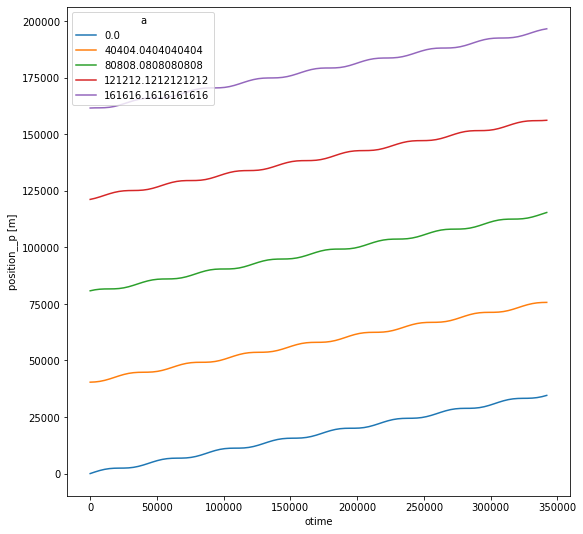

In [12]:
slice_step=20
out_ds.position__p.isel(a=slice(0,None,slice_step)).plot(x="otime", hue="a", figsize=(9,9))

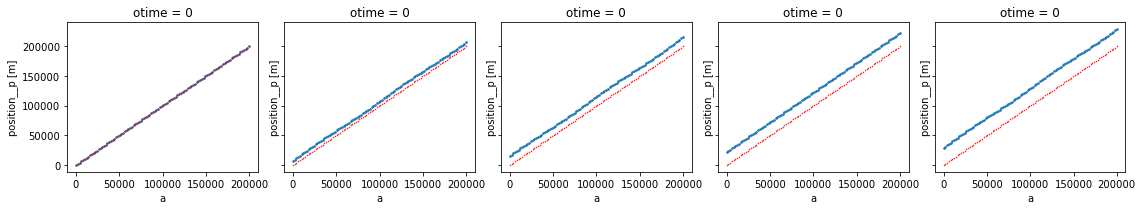

In [13]:
fg=out_ds.isel(otime=slice(0,None,slice_step)).plot.scatter(x="a", y="position__p", marker='.', s=10,col='otime')
for ax in fg.axes[0]:
    out_ds.isel(otime=0).plot.scatter(x="a", y="position__p", marker='.', c='red', s=1, ax=ax)

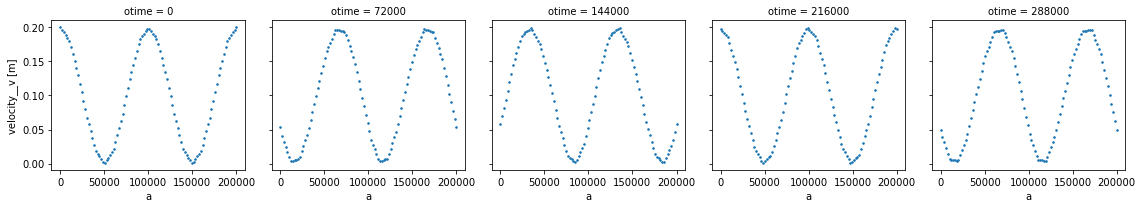

In [14]:
out_ds.isel(otime=slice(0,None,slice_step)).plot.scatter(x="a", y="velocity__v", marker='.', s=10,col='otime')